# Rotor Point Cloud
In the context of the shadow mapping simulation, the points constituting the turbine rotor disc are employed to accurately represent its geometry. Positioned strategically, these points serve as the origins for rays projected from the sun to the ground, effectively modeling the complete rotor disc. This arrangement enables a good approximation of shadow dynamics. This section provides insights into the calculation process of the rotor point cloud.

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import print_code, rotor_point_spacing, generate_turbine
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML

## Point Spacing
To approximate the rotor disc, firstly, a distribution of points is made across the entire rotor disc. This is done with the two following functions:

The first function, `rotor_point_spacing`, calculates the spacing of points within the rotor disc of a wind turbine. It adjusts the vertical grid element size based on the rotor angle, determines the grid resolution, and computes the number of points needed for each radius within the rotor disc. The function then generates lists of radii (r_list) and corresponding numbers of points per radius (n_list) based on the calculated grid resolution.

In [2]:
HTML(print_code(rotor_point_spacing))

The second function, `generate_turbine`, uses the information obtained from the first function to create a 3D point cloud representing the wind turbine's rotor disc. It considers the specified number of points along the radial and angular dimensions, the orientation of the turbine, and its coordinates. The function iterates through each radius and angle, calculating the relative Cartesian coordinates of each point within the rotor disc, and adjusts the coordinates based on the turbine's overall position. The resulting 3D point cloud captures the spatial distribution of points within the wind turbine's rotor disc.

In [3]:
HTML(print_code(generate_turbine))

Given a set of input parameters, the rotor points can be calculated:

In [4]:
diameter = 100
grid_element_size = np.array([10, 10, 10], dtype = float)
n_vector = np.array([1, 0.5])
turbine_cord = np.array([0, 0, 10])
angle = np.deg2rad(45)
r_list, n_angle = rotor_point_spacing(diameter, grid_element_size, angle)
points = generate_turbine(r_list, n_angle, n_vector, turbine_cord)

The points are thereafter displayed in a scatter plot:

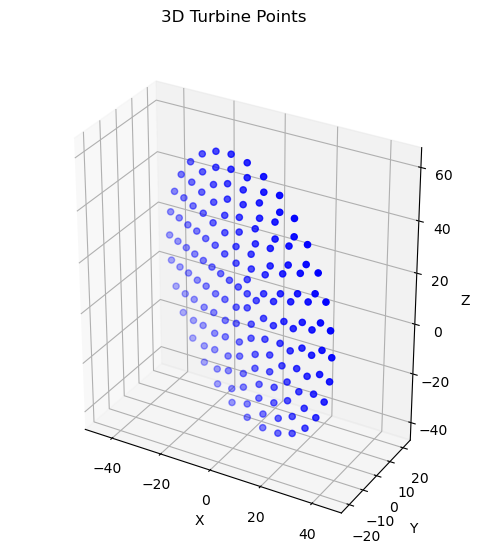

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6))
ax.scatter(*points.T, color='b', marker='o')
ax.set(xlabel= "X",
       ylabel = "Y",
       zlabel = "Z",
       aspect = "equal")
fig.suptitle('3D Turbine Points')
plt.show()

### Convertion to Voxel points
The ray tracing algorithm operates within a voxel environment, requiring only a single ray origin for each voxel. Consequently, the algorithm identifies all the voxels in contact with the points in the rotor disc. The center of each individual voxel is then utilized as the new ray origin. Since the rays travel in parallel during each temporal iteration of the shadow map solving algorithm, any error introduced by this approximation should be negligible.

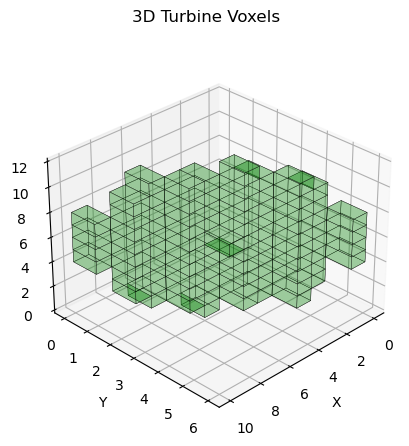

In [6]:
voxel_indices = np.floor(points / grid_element_size).astype(int)
voxel_indices = np.unique(voxel_indices, axis=0)
min_values = np.min(voxel_indices, axis=0) # Find the minimum value along each column (axis=0)
shifted_indices = voxel_indices - min_values # Add the absolute minimum value to shift all elements in each column
grid_dim = np.max(shifted_indices, axis=0) + 1 # Define grid dimensions based on the shifted indices
occupied_grid = np.zeros(grid_dim, dtype=bool) # Create an empty grid to represent the occupied voxels
occupied_grid[shifted_indices[:, 0], shifted_indices[:, 1], shifted_indices[:, 2]] = True # Mark the occupied voxels in the grid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(occupied_grid, color = "green", edgecolor='k', linewidth=0.2, alpha = 0.2)
ax.view_init(azim=45)
ax.set(xlabel= "X",
       ylabel = "Y",
       zlabel = "Z")
fig.suptitle('3D Turbine Voxels')
plt.show()

The original rotor disc points and the reduced voxel points can then be compared:

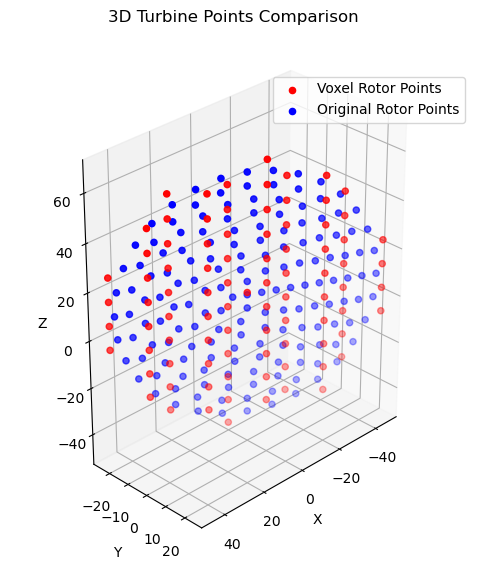

Percentage reduction in points: 45.96%


In [7]:
turbine_points = (voxel_indices+np.array([0.5, 0.5, 0.5])) * grid_element_size

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6))
ax.scatter(*turbine_points.T, color='r', marker='o', label = "Voxel Rotor Points")
ax.scatter(*points.T, color='b', marker='o', label = "Original Rotor Points")
ax.set(xlabel= "X",
       ylabel = "Y",
       zlabel = "Z",
       aspect = "equal")
ax.view_init(azim=45)
ax.legend()
fig.suptitle('3D Turbine Points Comparison')
plt.show()

print(f"Percentage reduction in points: {(len(points) - len(turbine_points))/ len(points) * 100:.2f}%")

Depending on the terrain resolution and turbine configuration, this optimization has the potential to reduce the computational time of the calculation by half.